In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("heart_2020_balanced.csv")
print(df.shape)
print(df.head(3))


(319795, 18)
  HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1              Yes  Very good        7.0     No            No         No  
2              Yes       Fair        8.0    Yes            No         No  


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns
categorical_columns = df.select_dtypes(include=["object"]).columns.drop("HeartDisease")

numeric_transformer = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer(
    transformers=[
        ("numerical", numeric_transformer, numeric_columns),
        ("categorical", categorical_transformer, categorical_columns)
    ]
)


In [3]:
from sklearn.model_selection import train_test_split

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [4]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ("preprocessing", preprocessing),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1))
])

model.fit(X_train, y_train)


,steps,"[('preprocessing', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Accuracy: 0.7487
Balanced accuracy: 0.7624
Precision (macro): 0.5980
Recall (macro): 0.7624
F1 (macro): 0.5955
Precision (weighted): 0.9088
Recall (weighted): 0.7487
F1 (weighted): 0.8018
ROC-AUC: 0.8408
Average Precision (PR-AUC): 0.3486

Classification report:
               precision    recall  f1-score   support

          No     0.9730    0.7459    0.8444     43863
         Yes     0.2229    0.7789    0.3466      4106

    accuracy                         0.7487     47969
   macro avg     0.5980    0.7624    0.5955     47969
weighted avg     0.9088    0.7487    0.8018     47969

Confusion matrix:
 [[32716 11147]
 [  908  3198]]


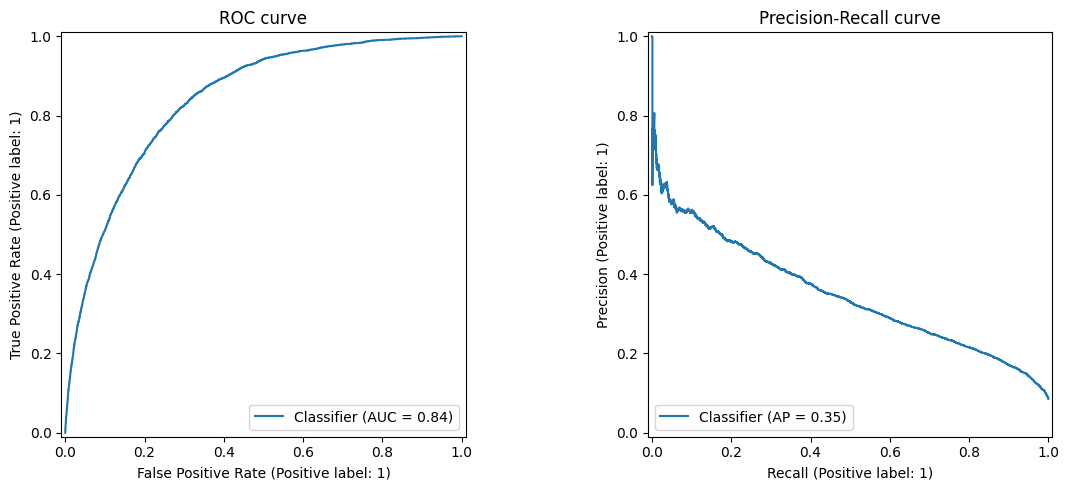

In [5]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)
# Probabilities for positive class "Yes"
y_proba = model.predict_proba(X_test)[:, 1]

y_true_bin = (y_test == "Yes").astype(int)

# Scalar metrics
acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
prec_weighted = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec_weighted = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)
bal_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_true_bin, y_proba)
ap = average_precision_score(y_true_bin, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Precision (macro): {prec_macro:.4f}")
print(f"Recall (macro): {rec_macro:.4f}")
print(f"F1 (macro): {f1_macro:.4f}")
print(f"Precision (weighted): {prec_weighted:.4f}")
print(f"Recall (weighted): {rec_weighted:.4f}")
print(f"F1 (weighted): {f1_weighted:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision (PR-AUC): {ap:.4f}")

print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
RocCurveDisplay.from_predictions(y_true_bin, y_proba, ax=axes[0])
axes[0].set_title("ROC curve")
PrecisionRecallDisplay.from_predictions(y_true_bin, y_proba, ax=axes[1])
axes[1].set_title("Precision-Recall curve")
plt.tight_layout()
plt.show()
